In [3]:
from glob import glob
import json
import os
import pickle
import sys
import time

import cv2
import h5py
from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [4]:
sys.path.append(r'C:\Users\lesliec\code')

In [5]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [6]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import subsample_lfp, remove_lfp_offset
# from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [7]:
%matplotlib widget

#### Plot electrodes

### Load experiment

In [8]:
# recfolder = r'E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_estim_2023-07-13_13-28-01\experiment1\recording1'
recfolder = r'E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_estim_2022-12-20_12-26-39\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [9]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


### Load EEG data

In [10]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [11]:
print(eeg_ts[0])
print(eeg_ts[-1])

52.67653295206478
4437.547815569076


In [12]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

### Load SWDs

In [13]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')

Whoope there it is


In [14]:
autoSWD_df.head()
# autoSWD_df[510:520]

,onset,offset,duration,spike_count,SWD_spike_times
0,62.907683,65.411671,2.503988,19,"[62.90768339318237, 63.042882738287446, 63.158..."
1,66.102868,68.190058,2.087190,16,"[66.1028679159616, 66.20286743157186, 66.30486..."
2,73.099234,74.083229,0.983995,9,"[73.09923402611828, 73.21323347391399, 73.3440..."
3,78.675207,81.261194,2.585987,17,"[78.67520701654675, 78.80320639652788, 78.9444..."
4,83.168785,84.357979,1.189194,10,"[83.16878525000968, 83.2935846454913, 83.42478..."


In [15]:
np.argmax(autoSWD_df['duration'].values)

156

Print some stats

In [16]:
print('Number of SWDs in {:d} min recording: {:d} events'.format(int((eeg_ts[-1]-eeg_ts[0])/60), len(autoSWD_df)))
print('Average SWD duration: {:.1f} s [min={:.1f}, max={:.1f}]'.format(
    np.mean(autoSWD_df['duration'].values), np.min(autoSWD_df['duration'].values), np.max(autoSWD_df['duration'].values)))
print('Total time spent in SWD: {:.1f} min'.format(np.sum(autoSWD_df['duration'].values)/60))

Number of SWDs in 73 min recording: 829 events
Average SWD duration: 2.8 s [min=0.5, max=11.5]
Total time spent in SWD: 39.3 min


## Plot some EEG signal

In [17]:
eeg_ts[:10]

array([52.67653295, 52.67693295, 52.67733295, 52.67773295, 52.67813294,
       52.67853294, 52.67893294, 52.67933294, 52.67973294, 52.68013293])

In [18]:
eeg_ts[-10:]

array([4437.54421555, 4437.54461555, 4437.54501555, 4437.54541556,
       4437.54581556, 4437.54621556, 4437.54661556, 4437.54701556,
       4437.54741557, 4437.54781557])

(-1.5, 1.5)

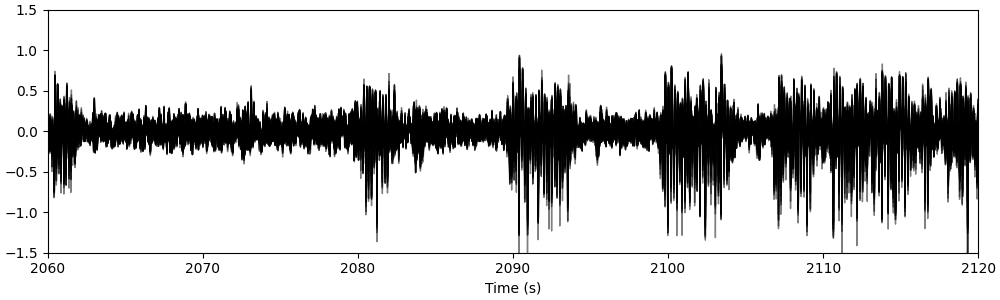

In [19]:
window = [2060, 2120]

fig, ax = plt.subplots(figsize=(10,3), constrained_layout=True)

eeginds = np.nonzero((eeg_ts > window[0]) & (eeg_ts < window[1]))[0]
# ax_eeg.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax.plot(eeg_ts[eeginds], filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
ax.set_xlim(window)
ax.set_xlabel('Time (s)')
ax.set_ylim([-1.5, 1.5])

### Load behavior videos

In [20]:
pupil_video = Movie(
    filepath = exp.pupilmovie_file,
    sync_filepath = exp.sync_file,
    sync_channel = 'eyetracking'
)
pupil_ts = pupil_video.sync_timestamps
body_video = Movie(
    filepath = exp.bodymovie_file,
    sync_filepath = exp.sync_file,
    sync_channel = 'behavior'
)
body_ts = body_video.sync_timestamps

In [21]:
print(pupil_ts[:10])
print(np.diff(pupil_ts)[:10])

[7.93841 7.95192 7.96929 8.0028  8.03608 8.06934 8.10263 8.13607 8.16937
 8.20274]
[0.01351 0.01737 0.03351 0.03328 0.03326 0.03329 0.03344 0.0333  0.03337
 0.03729]


In [22]:
print(body_ts[:10])
print(np.diff(body_ts)[:10])

[7.99601 8.01347 8.01633 8.03318 8.04988 8.06652 8.08303 8.1     8.11642
 8.13317]
[0.01746 0.00286 0.01685 0.0167  0.01664 0.01651 0.01697 0.01642 0.01675
 0.02231]


### Set up video clips

## Make video

In [23]:
def update(clock_time):
    
    # body cam movie
    bplot.set_data(body_video.get_frame(time=clock_time, timestamps='sync'))

    # pupil cam movie
    pplot.set_data(pupil_video.get_frame(time=clock_time, timestamps='sync'))

    # eeg plot
    # spline.set_data([clock_time - SWDevent.onset, clock_time - SWDevent.onset], [-1,1])
    spline.set_data([clock_time, clock_time], [-1,1])
    
    return fig

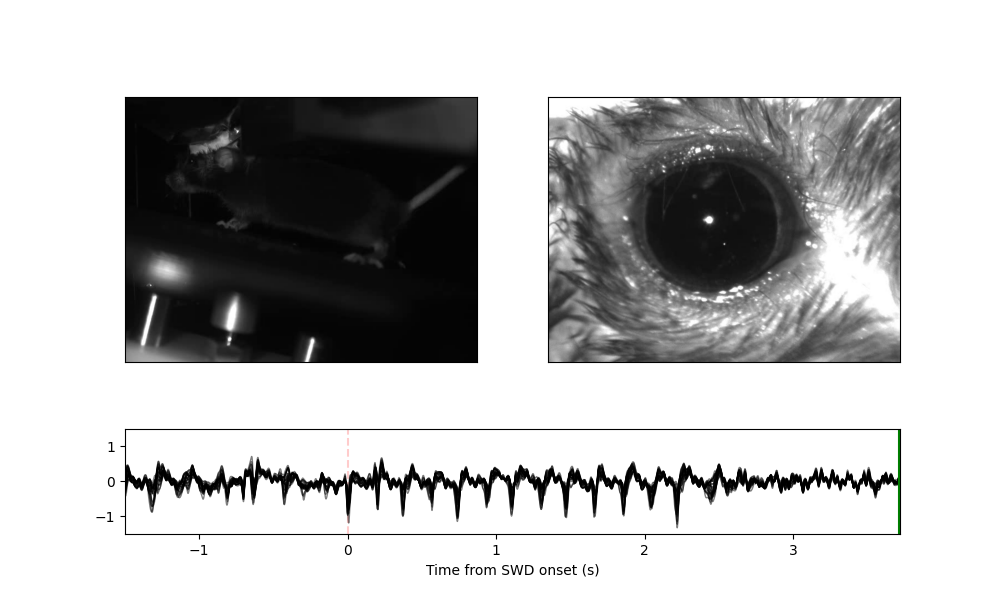

In [32]:
SWDind = 512
SWDevent = autoSWD_df.iloc[SWDind]
deltat = 1.5
plotwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

movie_name = os.path.join(plotsavedir, 'SWD{:d}_EEG_videos.mp4'.format(SWDind))
frame_times = pupil_ts[np.nonzero((pupil_ts > plotwin[0]) & (pupil_ts < plotwin[1]))[0]]

fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('whitesmoke')
# make grid for subplots
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 1])
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_eeg = fig.add_subplot(gs[1, :])
# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)
# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)
# EEG plot
eeginds = np.nonzero((eeg_ts > plotwin[0]) & (eeg_ts < plotwin[1]))[0]
ax_eeg.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax_eeg.plot(eeg_ts[eeginds] - SWDevent.onset, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
ax_eeg.set_xlim(plotwin - SWDevent.onset)
ax_eeg.set_xlabel('Time from SWD onset (s)')
ax_eeg.set_ylim([-1.5, 1.5])
spline = ax_eeg.axvline(plotwin[0] - SWDevent.onset, color='g')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=60, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=10, extra_args=['-vcodec', 'libx264'], dpi=300)

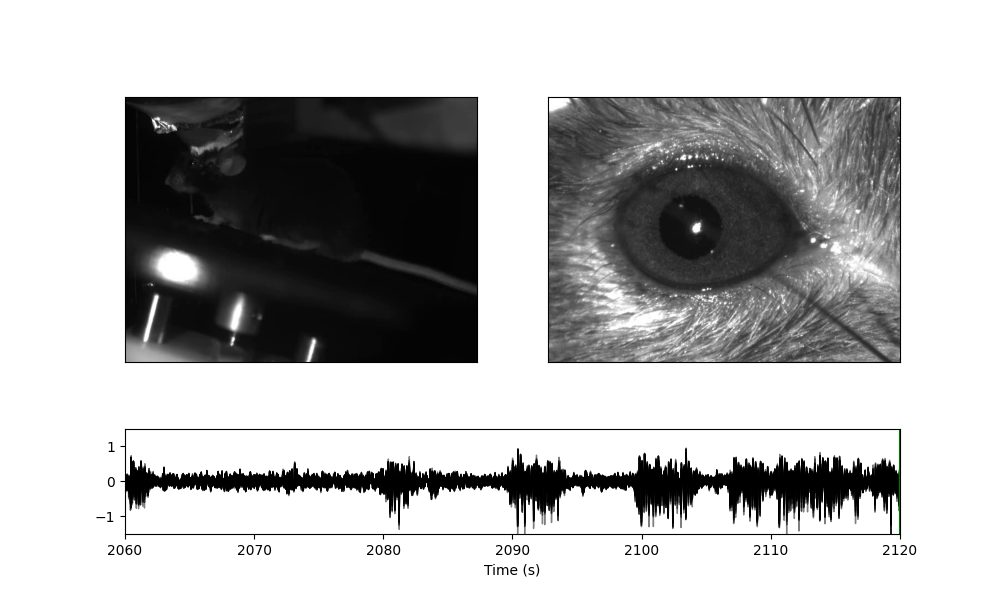

In [24]:
window = [2060, 2120]

movie_name = os.path.join(plotsavedir, 'window2_EEG_videos.mp4')
frame_times = pupil_ts[np.nonzero((pupil_ts > window[0]) & (pupil_ts < window[1]))[0]]

fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('whitesmoke')
# make grid for subplots
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 1])
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_eeg = fig.add_subplot(gs[1, :])
# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=window[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)
# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=window[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)
# EEG plot
eeginds = np.nonzero((eeg_ts > window[0]) & (eeg_ts < window[1]))[0]
ax_eeg.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax_eeg.plot(eeg_ts[eeginds], filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
ax_eeg.set_xlim(window)
ax_eeg.set_xlabel('Time (s)')
ax_eeg.set_ylim([-1.5, 1.5])
spline = ax_eeg.axvline(window[0], color='g')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=60, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

### Load units and spikes

In [14]:
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,other-TH
1,B4,probeB,1,3640,0.508208,AMv,253,179,195,other-TH
2,B9,probeB,3,3620,0.590620,AMv,253,178,195,other-TH
3,B10,probeB,4,3600,0.480737,AMv,253,177,194,other-TH
4,B11,probeB,5,3600,0.480737,AMv,253,177,194,other-TH


In [15]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

HIP: 113 units
MO: 73 units
PAL: 69 units
RT-TH: 12 units
SM-TH: 59 units
SS: 135 units
STR: 97 units
VIS: 24 units
other-TH: 208 units


### Load LFP

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeD', 'probeF']


In [ ]:
LFP_traces = {}
for pbi, probei in enumerate(probe_list):

In [17]:
probei = 'probeD'

lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
lfp_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', shape=(lfp_ts.size, exp.ephys_params[probei]['num_chs']), mode='r')

In [18]:
print(lfp_ts.shape)
print(lfp_mm.shape)

(16506874,)
(16506874, 384)


In [19]:
with open(exp.ephys_params[probei]['probe_info']) as data_file:
    data = json.load(data_file)
    
## Get info ##
npx_allch = np.array(data['channel']) # this is an array from 0 to 384
surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
air_ch = int(data['air_channel']) # the electrode at the ACSF/air border
allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip
ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"

print(surface_ch)
print(air_ch)

370
384


In [20]:
allch_areas = np.array(data['area_ch'])
print(np.unique(allch_areas))

['CP' 'RT' 'SSp-bfd1' 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a'
 'SSp-bfd6b' 'VAL' 'VL' 'VPL' 'ccb' 'em' 'fi' 'fiber tracts' 'null' 'or'
 'st']


In [30]:
ROI = 'SSp'
ROImask = [True if ROI in x else False for x in allch_areas]
print(np.sum(ROImask))

125


Testing

In [23]:
SWDind = 40
SWDevent = autoSWD_df.iloc[SWDind]
deltat = 1.0

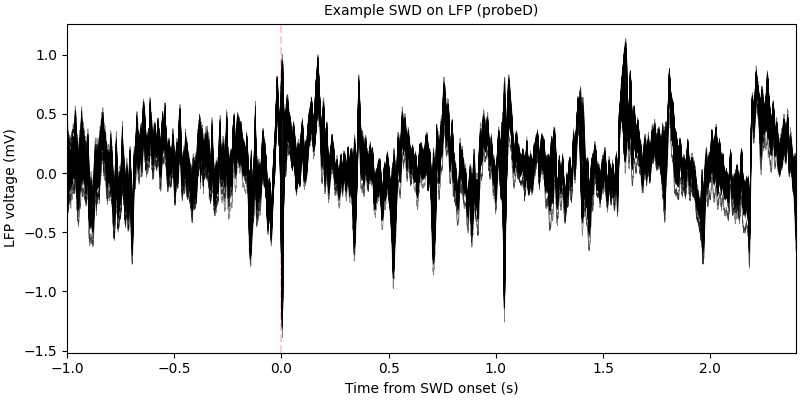

In [26]:
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
ax.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :][:, ROImask] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
# ax.plot(lfp_ts[tsinds] - timezero, saline_ref[tsinds] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='m', linewidth=1.0, alpha=0.8)
ax.set_xlim(pwin - timezero)
ax.set_xlabel('Time from SWD onset (s)')
ax.set_ylabel('LFP voltage (mV)')
ax.set_title('Example SWD on LFP ({})'.format(probei))

### SAVE ###
fig_name = 'SWD_LFPonly_example{:d}.png'.format(SWDind)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Plot an SWD event

In [32]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'VIS', 'SS', 'MO']

In [53]:
SWDind = 257
SWDevent = autoSWD_df.iloc[SWDind]
print(SWDevent.duration)

1.339186593469094


In [59]:
deltat = 1.0 # time around SWD to plot, s

Plot EEG + LFP + all region raster

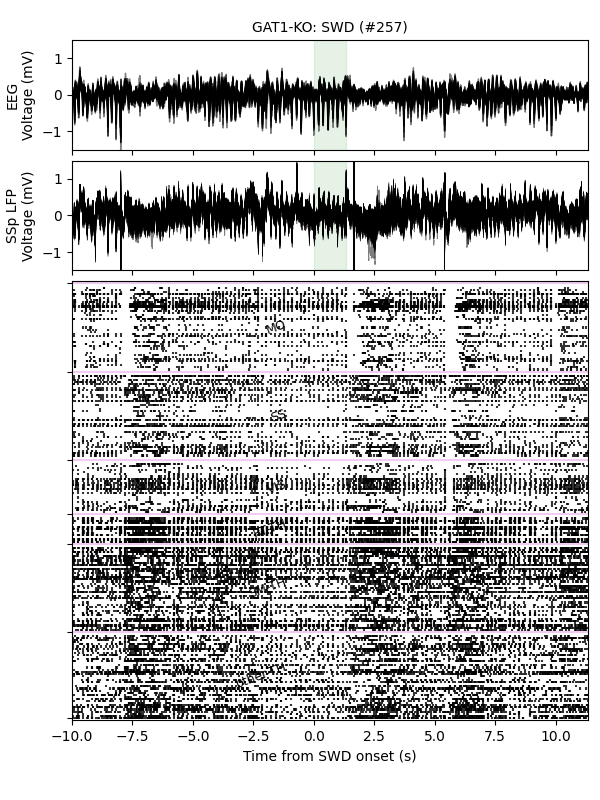

In [60]:
## Plot one half-slide ##
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
umax = 40

fig = plt.figure(figsize=(6, 8)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=3, left=0.12, right=0.98, top=0.95, bottom=0.1, hspace=0.05, height_ratios=[1, 1, 4])
EEGax = fig.add_subplot(gs[0])
LFPax = fig.add_subplot(gs[1])
rasterax = fig.add_subplot(gs[2])

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > pwin[0]) & (eeg_ts < pwin[1]))[0]
EEGax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
EEGax.plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
EEGax.set_xlim(pwin - timezero)
EEGax.set_xticklabels([])
EEGax.set_ylim([-1.5, 1.5])
# EEGax.set_ylim([-0.25, 0.25])
EEGax.set_ylabel('EEG\nVoltage (mV)')
EEGax.set_title('GAT1-KO: SWD (#{:d})'.format(SWDind))
# EEGax.set_title('Wild type (not litter mate): spontaneous activity')

## Plot LFP ##
tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
LFPax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
LFPax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :][:, ROImask] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
LFPax.set_xlim(pwin - timezero)
LFPax.set_xticklabels([])
LFPax.set_ylim([-1.5, 1.5])
LFPax.set_ylabel('{} LFP\nVoltage (mV)'.format(ROI))

## Plot raster ##
# rasterax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwin[0]) & (uspiketimes < pwin[1]))[0]
        ]
        rasterax.eventplot(SWDspikes - timezero, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(-1.05, last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwin - timezero)
rasterax.set_xlabel('Time from SWD onset (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
fig_name = 'SWD_EEG_LFP_NPX_example{:d}.png'.format(SWDind)
# fig_name = 'spont_EEG_NPX_example.png'
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)